# Detecting the stego app by its use of LSB steganography

## Initialization

First we need to import the extraction functions of [Extract LSBs](./extract-lsbs.ipynb).

In [1]:
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import sys

sys.path.extend(['../tools/aletheia'])
import aletheialib.attacks as attacks

## Define constants

In [2]:
STEGOAPPDB_PATH = Path('../datasets/StegoAppDB_stegos_20240309-030352')
INFO_FILE = STEGOAPPDB_PATH / 'StegoAppDB_stegos_20240309-030352_stego_directory.csv'
COVERS_PATH = STEGOAPPDB_PATH / 'covers'
STEGOS_PATH = STEGOAPPDB_PATH / 'stegos'
METHOD_COLUMN = 'embedding_method'
STEGO_COLUMN = 'image_filename'
COVER_COLUMN = 'cover_image_filename'

## Collect stego images

We will read the info file to collect all embedding methods and the stego images that were generated using them.

### Gather embedding methods

The embedding methods can be found in the `METHOD_COLUMN` of the info file.

In [3]:
info_file = pd.read_csv(INFO_FILE)
embedding_methods = info_file[METHOD_COLUMN].unique()
print(f'Found the following embedding methods: {", ".join(embedding_methods)}')

Found the following embedding methods: MobiStego, PixelKnot, PocketStego, Pictograph, SteganographyM, Passlok


### Collect stego images

Now, for each embedding method, we will collect the stego images that were generated with it.

In [4]:
def collect_stego_images(embedding_method: str):
    return info_file[info_file[METHOD_COLUMN] == embedding_method][STEGO_COLUMN]


stego_images_by_method = {method: STEGOS_PATH / collect_stego_images(method) for method in embedding_methods}
{method: len(stego_images) for method, stego_images in stego_images_by_method.items()}

{'MobiStego': 3060,
 'PixelKnot': 3060,
 'PocketStego': 3060,
 'Pictograph': 4800,
 'SteganographyM': 3060,
 'Passlok': 1530}

In [5]:
def for_each_image(func, take=None, filter_methods=None):
    """Helper function to iterate over all stego images and apply a function to them."""
    filter_methods = (lambda x: True) if filter_methods is None else filter_methods

    for method, stego_images in stego_images_by_method.items():
        if not filter_methods(method):
            continue

        for channels in ['RGB', 'RGBA', 'A', 'R', 'G', 'B']: # Sorted by most likely occurence; other combination possible
            for bits in [1, 2, 4]: # Other bits (e.g. 3) possible but higher computation time
                for endian in ['little', 'big']:
                    for direction in ['row', 'column']:
                        yield func(stego_images[:take] if take is not None else stego_images, (method, channels, bits, endian, direction))

## Known message attack

In [6]:
MESSAGE_DIR = Path('../datasets/StegoAppDB_stegos_20240309-030352/message_dictionary')


def find_nth_substring(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start + len(needle))
        n -= 1
    return start


def get_original_message(stego_img):
    img_row = info_file[info_file['image_filename'] == stego_img.name]
    msg_name = img_row['message_dictionary'].values[0]
    starting_line_index = img_row['message_starting_index'].values[0]
    msg_len = img_row['message_length'].values[0]
    full_msg = (MESSAGE_DIR / msg_name).read_text()
    start_index = find_nth_substring(full_msg, '\n', starting_line_index - 1) + 1
    return full_msg[start_index:start_index + msg_len].encode('utf-8')


def get_embedded_message(stego_img, bits, endian, channels, direction):
    return attacks.lsb_extract(stego_img, bits, channels=channels, endian=endian, direction=direction).tobytes()


def detect_used_method_and_bits(stego_images, path_parts):
    method, channels, bits, endian, direction = path_parts
    results = []
    for stego_img in tqdm(stego_images, desc=f'Cycling through {method} {channels} {bits}-LSB {endian} {direction}'):
        original_msg = get_original_message(stego_img)
        extracted_msg = get_embedded_message(stego_img, bits, endian, channels, direction)
        index = extracted_msg.find(original_msg)
        if index != -1:
            results.append((method, channels, bits, endian, direction, index))

    rate = len(results) / len(stego_images)
    results = set(results)
    if len(results) == 1:
        return rate, results.pop()
    elif len(results) > 1:
        return rate, results
    else:
        return rate, None


#detected_used_method_and_bits = await detect_used_method_and_bits(
#    stego_images_by_method['PocketStego'][:10],
#    ('PocketStego', 'B', 1, 'MSB')
#)
detected_used_method_and_bits = [
    (rate, values) 
    for rate, values in for_each_image(detect_used_method_and_bits, take=10) 
]

Cycling through MobiStego RGB 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGB 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego RGBA 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego A 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego R 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego G 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through MobiStego B 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGB 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot RGBA 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot A 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot R 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot G 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PixelKnot B 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGB 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego RGBA 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego A 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego R 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego G 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through PocketStego B 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGB 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph RGBA 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph A 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph R 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph G 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Pictograph B 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGB 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM RGBA 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM A 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM R 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM G 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through SteganographyM B 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGB 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok RGBA 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok A 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok R 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok G 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 1-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 1-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 1-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 1-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 2-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 2-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 2-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 2-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 4-LSB little row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 4-LSB little column:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 4-LSB big row:   0%|          | 0/10 [00:00<?, ?it/s]

Cycling through Passlok B 4-LSB big column:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
pd.DataFrame(((rate, *values) for rate, values in detected_used_method_and_bits if values is not None), columns=['rate', 'method', 'channels', 'bits', 'endian', 'direction', 'index'])

,rate,method,channels,bits,endian,direction,index
0,1.0,MobiStego,RGB,2,big,row,3
1,1.0,PocketStego,B,1,big,column,0


## Detecting PocketStego

In the paper 'Tackling Android Stego Apps in the Wild', it is stated that PocketStego should be detected by the use of 1-LSB steganography in the blue channel. We will now check if this is true for the stego images in the StegoAppDB.

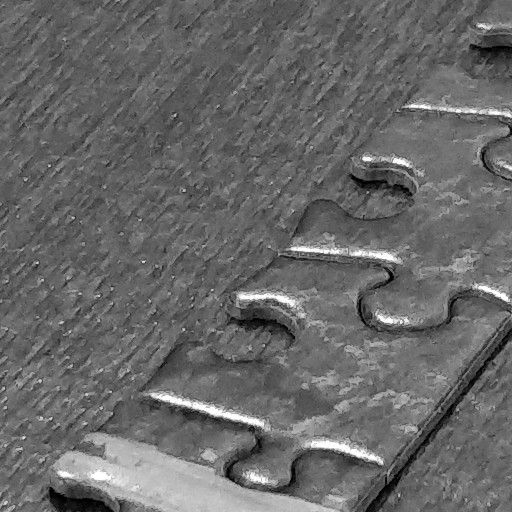

In [12]:
from PIL import Image

stego_path = STEGOS_PATH / '260484.PNG'
stego = Image.open(stego_path)
stego

In [13]:
expected_msg = get_original_message(stego_path)
expected_msg

b"CYMBELINE\nWhat's this, Comelius?\nCORNELIUS\nThe queen, sir, very oft importuned me\nTo temper poisons for her, still pretending\nThe satisfaction of her knowledge only\nIn killing creatures vile, as cats and dogs,\nOf no esteem: I, dreading that her purpose\nWas of more danger, did compound for her\nA certain stuff, which, being ta'en, would cease\nThe present power of life, but in short time\nAll offices of nature should again\nDo their due functions. Have you ta'en of it?\nIMOGEN\nMost like I did, for I was dead.\nBELARIUS\nMy boys,\nThere was our error.\nGUIDERIUS\nThis is, sure, Fidele.\nIMOGEN\nWhy did you throw your wedded lady from you?\nThink that you are upon a rock; and now\nThrow me again.\nEmbracing him\nPOSTHUMUS LEONATUS\nHang there like a fruit, my soul,\nTill the tree die!\nCYMBELINE\nHow now, my flesh, my child!\nWhat, makest thou me a dullard in this act?\nWilt thou not speak to me?\nIMOGEN\n[Kneeling] Your blessing, sir.\nBELARIUS\n[To GUIDERIUS and ARVIRAGUS] Th

In [14]:
first_word = np.frombuffer(expected_msg[:9], dtype=np.uint8)
first_word

array([67, 89, 77, 66, 69, 76, 73, 78, 69], dtype=uint8)

In [15]:
first_word_bin = np.unpackbits(first_word)
first_word_bin

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1], dtype=uint8)

In [16]:
len(first_word_bin)

72

In [17]:
pixels = list(stego.getpixel((0, end))[2] for end in range(72))
pixels

[80,
 77,
 98,
 112,
 96,
 86,
 107,
 107,
 98,
 85,
 82,
 77,
 83,
 94,
 94,
 105,
 100,
 99,
 98,
 108,
 103,
 75,
 76,
 113,
 110,
 123,
 120,
 114,
 104,
 94,
 101,
 98,
 96,
 97,
 94,
 92,
 90,
 83,
 84,
 97,
 94,
 91,
 86,
 90,
 79,
 81,
 112,
 116,
 100,
 93,
 86,
 84,
 97,
 92,
 86,
 113,
 114,
 101,
 92,
 84,
 87,
 97,
 97,
 96,
 94,
 95,
 100,
 100,
 94,
 95,
 96,
 91]

In [18]:
bit_str = ''.join(bin(p)[-1] for p in pixels)
bit_str

'010000110101100101001101010000100100010101001100010010010100111001000101'

In [19]:
np.packbits(np.array([int(bit) for bit in bit_str]))

array([67, 89, 77, 66, 69, 76, 73, 78, 69], dtype=uint8)

In [51]:
# Reshape (height, width, channels) to (width, height, channels) and extract blue channel
arr = np.array(stego)
arr.transpose(1, 0, 2)[:, :, [1,2]].reshape(-1)[:9]
#arr.T[2].reshape(-1)[:9]

array([ 81,  80,  77,  77,  99,  98, 112, 112,  97], dtype=uint8)

In [ ]:
#extracted_msg = attacks.lsb_extract(stego_path, 1, channels='B', endian='little')

def _extract_bits_opt_big(data):
    msg = np.zeros((len(data) // 8), dtype=np.uint8)
    for i in range(8):
        msg |= (data[i::8] & 1) << 7 - i
    return msg

extracted_msg = _extract_bits_opt_big(np.array(stego).transpose(1, 0, 2)[:, :, 2].reshape(-1))
extracted_msg[:9]

In [ ]:
extracted_msg.tobytes()